In [1]:
# -*- coding: utf-8 
import math
import os
import time
import random

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from Libraries import Functions_PreprocessTrackingData as funcs
from Libraries.Functions_PreprocessTrackingData import PlotSituation
from Libraries.Functions_PreprocessTrackingData import PlotSituation2
from Libraries import Dictionaries as dicts

from tqdm import tqdm
import pandas as pd

import json
import math
import pickle


import numpy as np

from matplotlib.patches import Arc


from copy import deepcopy

In [6]:
min_frame = 0
max_frames = minute2frame(45)

In [7]:
def plot_at_frame(frame):
    team_index = players_team_id[frame].astype(int).reshape(len(players_team_id[frame]),)
    players_in_play = funcs.GetPlayersInPlay(players_position_not_transf,frame)
    [players_position,ball_position] = funcs.TransformCoords(players_position_not_transf,ball_position_not_transf)
    color_home='green'
    color_away='yellow'
    funcs.PlotSituation(players_position[frame][players_in_play],
                      ball_position[frame-10:frame],team_index[players_in_play],
                      frame,players_jersey[players_in_play],color_home,color_away)
    return

In [8]:
file_name = '20190722.Hammarby-IFElfsborg'
#file_name = '20191020.Hammarby-MalmöFF'
#file_name = '20190930.Hammarby-Örebro'

#Names of the teams playing in OPTA format
home_team_name = 'Hammarby IF'
away_team_name = 'IF Elfsborg'
#away_team_name = 'Malmö FF'
#away_team_name = 'Örebro SK'
year = file_name[:4]

#First '.1' or second '.2' half of the match
data_file_name=file_name+'.1'




In [9]:
[ball_position_not_transf,players_position_not_transf,players_team_id,events,players_jersey,
     info_match,names_of_players] = LoadDataHammarbyNewStructure2020(data_file_name,'../Signality/2019/Tracking Data/')


Loading data, this might take some seconds...


100%|██████████| 67500/67500 [00:10<00:00, 6257.87it/s]

Data has been loaded



In [10]:
# DATAFRAME with, player position x, player position y, row is the frame
# frame_no = 100
player_index = 15
print(players_jersey[player_index])
print(players_team_id[100][player_index])
print(names_of_players[player_index])
# layers_in_play = funcs.GetPlayersInPlay(players_position_not_transf,frame_no) 
[players_position,ball_position] = funcs.TransformCoords(players_position_not_transf,ball_position_not_transf) 



7
2
Imad Khalili


In [11]:
given_player_positions = [x[player_index] for x in players_position]
opposition_indexes = [index for index, id in enumerate(players_team_id[100]) if id!=2]
teammate_indexes = [index for index, id in enumerate(players_team_id[100]) if id==2 and index!=player_index]

# Opposition positions
opposition_players_positions = [x[opposition_indexes] for x in players_position]
closest_distance_to_opposition = []
for i in tqdm(range(len(opposition_players_positions))):
    distance_to_given_player = np.inf
    for j in range(len(opposition_players_positions[i])):
        distance_to_given_player = min(distance_to_given_player, np.sqrt( (given_player_positions[i][0] - opposition_players_positions[i][j][0])**2 + (given_player_positions[i][0] - opposition_players_positions[i][j][0])**2 ))
    closest_distance_to_opposition.append(distance_to_given_player)


teammate_players_positions = [x[teammate_indexes] for x in players_position]
closest_distance_to_teammate = []
for i in tqdm(range(len(teammate_players_positions))):
    distance_to_given_player = np.inf
    for j in range(len(teammate_players_positions[i])):
        distance_to_given_player = min(distance_to_given_player, np.sqrt( (given_player_positions[i][0] - teammate_players_positions[i][j][0])**2 + (given_player_positions[i][0] - teammate_players_positions[i][j][0])**2 ))
    closest_distance_to_teammate.append(distance_to_given_player)

100%|██████████| 67500/67500 [00:04<00:00, 16243.08it/s]


In [12]:

df_player = pd.DataFrame(given_player_positions, columns = ["X_pos", "Y_pos"])
df_player["dist"] = np.nan
df_player["d_dist"] = np.nan
df_player["d_dist_kmh"] = np.nan
df_player["d_dist_kmh2"] = np.nan
df_player["dist_to_nearest_op"] = np.nan
df_player["dist_to_ball"] = np.nan
df_player["dist_to_nearest_teammate"] = np.nan
df_player["dist_to_goal"] = np.nan

In [13]:
for index in tqdm(range(5, df_player.shape[0])):
    #calculate \delta dist
    df_player.at[index,"dist"] = np.sqrt((df_player.at[index,"X_pos"] - df_player.at[index-5,"X_pos"])**2 + (df_player.at[index,"Y_pos"] - df_player.at[index-5,"Y_pos"])**2) # Euclidean distance
    
    #calculate speed = \delta dist devided by \delta time, d_dist = speed
    df_player.at[index,"d_dist"] = df_player.at[index,"dist"] / (5/25)
    #speed converted to km/hr, d_dist_kmh is speed in km/hr
    df_player.at[index,"d_dist_kmh"]= df_player.at[index,"d_dist"] * 3.6
    
    #calculate acceleration = \delta speed devided by \delta time, d_dist_kmh2 is acceleration in km/hr^2
    df_player.at[index,"d_dist_kmh2"] = (df_player.at[index,"d_dist_kmh"] - df_player.at[index-1,"d_dist_kmh"]) / (1/(25*3600))
    
    df_player.at[index, "dist_to_nearest_op"] = closest_distance_to_opposition[index]

    df_player.at[index, "dist_to_nearest_teammate"] = closest_distance_to_teammate[index]

    df_player.at[index, "dist_to_ball"] = np.sqrt((df_player.at[index,"X_pos"] - ball_position[index][0])**2 + (df_player.at[index,"Y_pos"] - ball_position[index][0])**2) # Euclidean distance

    goal_x_pos = 0
    goal_y_pos = 34.2
    df_player.at[index, "dist_to_goal"] = np.sqrt((df_player.at[index,"X_pos"] - goal_x_pos)**2 + (df_player.at[index,"Y_pos"] - goal_y_pos)**2)

100%|██████████| 67495/67495 [00:08<00:00, 8286.98it/s]


In [14]:
#to get the largest coordinate for x
print(max(df_player["X_pos"]))
print(min(df_player["X_pos"]))
print(np.nanmax(df_player["dist_to_goal"]))
print(np.nanmin(df_player["dist_to_goal"]))

96.58
-104.6
146.51935025790962
1.9003157632351533


In [15]:
player_2_plot = names_of_players[player_index]

No handles with labels found to put in legend.


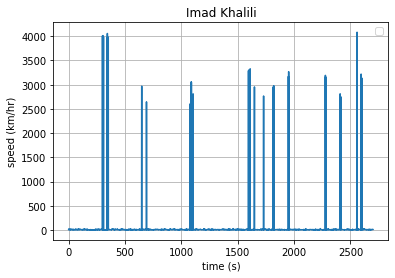

In [16]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(np.arange(10/25, len(given_player_positions)/25, 1/25), df_player["d_dist_kmh"].to_numpy()[10:len(given_player_positions)])
legend_text = player_2_plot
plt.title(legend_text)
plt.xlabel('time (s)')
plt.ylabel('speed (km/hr)')
plt.grid()
ax.legend()
figure_name = player_2_plot + ' speed'
fig.savefig('figs/'+figure_name+'.png', bbox_inches='tight')

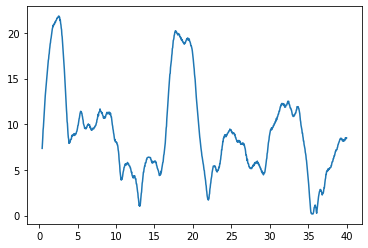

In [17]:
df_player.at[20, "d_dist_kmh"]
time_x_axis = np.arange(10/25, 1000/25, 1/25)
plt.plot(time_x_axis, df_player["d_dist_kmh"].to_numpy()[10:1000])

In [18]:
#####1st goal
start_f = int(minute2frame(18.5))
end_f = int(minute2frame(19.7))
freq_f = 25
start_s = start_f/freq_f #in seconds
end_s = end_f/freq_f #in seconds
print(start_f)
print(end_f)

27750
29550


In [19]:
# #####4th goal
# start_f = int(minute2frame(39))
# end_f = int(minute2frame(40))
# freq_f = 25
# start_s = start_f/freq_f #in seconds
# end_s = end_f/freq_f #in seconds
# print(start_f)
# print(end_f)

In [20]:
# ##### 3rd goal
# start_f = int(minute2frame(30.4))
# end_f = int(minute2frame(32))
# freq_f = 25
# start_s = start_f/freq_f #in seconds
# end_s = end_f/freq_f #in seconds
# print(start_f)
# print(end_f)

No handles with labels found to put in legend.


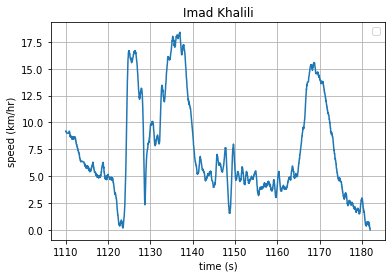

In [21]:
fig = plt.figure()
ax = plt.subplot(111)
#ax.plot(np.arange(t_start, t_end), df_player["d_dist_kmh"].to_numpy()[t_start:t_end])


ax.plot(np.arange(start_s, end_s, 1/25), df_player["d_dist_kmh"].to_numpy()[start_f:end_f])
#ax.plot(np.arange(10/25, 1000/25, 1/25), df_player["d_dist_kmh"].to_numpy()[10:1000])
legend_text = player_2_plot
plt.title(legend_text)
plt.xlabel('time (s)')
plt.ylabel('speed (km/hr)')
plt.grid()
ax.legend()
figure_name = player_2_plot + ' speed'
fig.savefig('figs/'+figure_name+'.png', bbox_inches='tight')

No handles with labels found to put in legend.


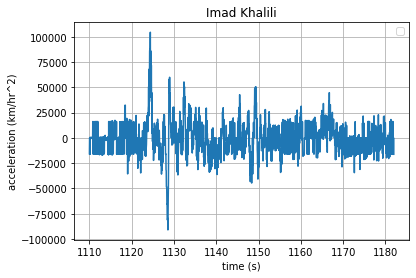

In [22]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(np.arange(start_s, end_s, 1/25), df_player["d_dist_kmh2"].to_numpy()[start_f:end_f])
legend_text = player_2_plot
plt.title(legend_text)
plt.xlabel('time (s)')
plt.ylabel('acceleration (km/hr^2)')
plt.grid()
ax.legend()
figure_name = player_2_plot + ' acceleration'
fig.savefig('figs/'+figure_name+'.png', bbox_inches='tight')

No handles with labels found to put in legend.


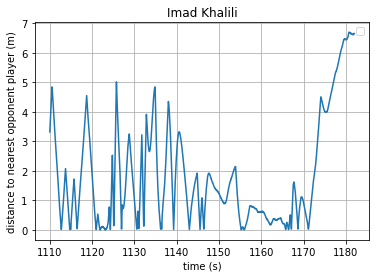

In [23]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(np.arange(start_s, end_s, 1/25), df_player["dist_to_nearest_op"].to_numpy()[start_f:end_f])
legend_text = player_2_plot
plt.title(legend_text)
plt.xlabel('time (s)')
plt.ylabel('distance to nearest opponent player (m)')
plt.grid()
ax.legend()
figure_name = player_2_plot + 'distance2opponent'
fig.savefig('figs/'+figure_name+'.png', bbox_inches='tight')

No handles with labels found to put in legend.


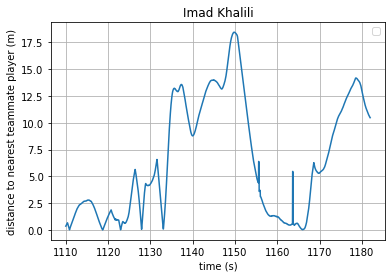

In [24]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(np.arange(start_s, end_s, 1/25), df_player["dist_to_nearest_teammate"].to_numpy()[start_f:end_f])
legend_text = player_2_plot
plt.title(legend_text)
plt.xlabel('time (s)')
plt.ylabel('distance to nearest teammate player (m)')
plt.grid()
ax.legend()
figure_name = player_2_plot + ' distance2teammate'
fig.savefig('figs/'+figure_name+'.png', bbox_inches='tight')

No handles with labels found to put in legend.


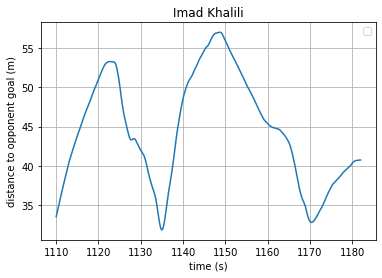

In [25]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(np.arange(start_s, end_s, 1/25), df_player["dist_to_goal"].to_numpy()[start_f:end_f])
legend_text = player_2_plot
plt.title(legend_text)
plt.xlabel('time (s)')
plt.ylabel('distance to opponent goal (m)')
plt.grid()
ax.legend()
figure_name = player_2_plot + ' distance2goal'
fig.savefig('figs/'+figure_name+'.png', bbox_inches='tight')

In [26]:
def minute2frame(minute):
    #each second has 25 frames, 1 min = 60 sec
    frame = minute * 60 * 25 
    return frame

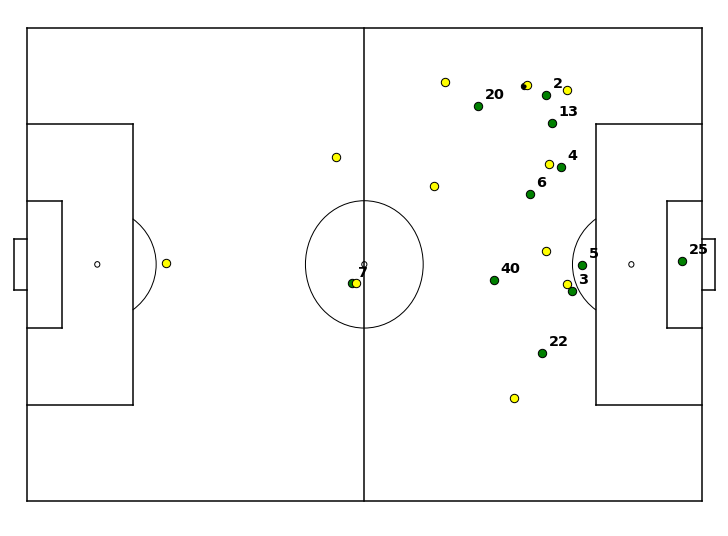

In [27]:
plot_at_frame(61005)

In [28]:
# TO-DO: 
# linear regression to smooth out the player direction line
# visualization tweaks: position line color and size tweaks

def plot_at_frame2(frame):
    team_index = players_team_id[frame-10:frame] # .astype(int).reshape(len(players_team_id[frame]),)
    players_in_play = funcs.GetPlayersInPlay(players_position_not_transf,frame) # TO-DO check if this affects direction calculaiton
    [players_position,ball_position] = funcs.TransformCoords(players_position_not_transf,ball_position_not_transf) 
    color_home='green'
    color_away='yellow'
    funcs.PlotSituation2([x[players_in_play] for x in players_position[frame-10:frame]],
                      ball_position[frame-10:frame],[x[players_in_play] for x in team_index],
                      frame,players_jersey[players_in_play],color_home,color_away)
    return

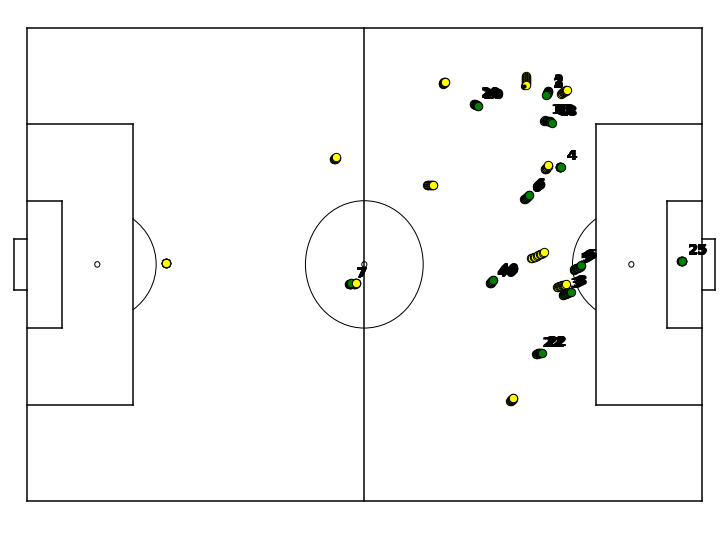

In [29]:
plot_at_frame2(61005)

In [3]:
def plot_at_frame(frame):
    team_index = players_team_id[frame].astype(int).reshape(len(players_team_id[frame]),)
    players_in_play = funcs.GetPlayersInPlay(players_position_not_transf,frame)
    [players_position,ball_position] = funcs.TransformCoords(players_position_not_transf,ball_position_not_transf)
    color_home='green'
    color_away='yellow'
    funcs.PlotSituation(players_position[frame][players_in_play],
                      ball_position[frame-10:frame],team_index[players_in_play],
                      frame,players_jersey[players_in_play],color_home,color_away)
    return

In [4]:
def LoadDataHammarbyNewStructure2020(data_file_name,raw_dir):
    print()
    print('Loading data, this might take some seconds...')
    
    info_dir = raw_dir+data_file_name+'-info_live.json'
    tracks_dir = raw_dir+data_file_name+'-tracks.json'
    events_dir = raw_dir+data_file_name+'-events.json'

    with open(info_dir) as json_data:
        info = json.load(json_data)

    with open(tracks_dir) as json_data:
        data = json.load(json_data)

    with open(events_dir) as json_data:
        events = json.load(json_data)
        
    # Add to info, so that is the same as the non-live
    info['home_team'] = {}
    info['home_team']['name'] = info['team_home_name']
    info['away_team'] = {}
    info['away_team']['name'] = info['team_away_name']

    #Get the track ids of all the players to stablish the order in the rest of arrays
    order_list = []
    players_jersey = []
    players_names = []
    players_team_id = []
    players_team_id_list = []

    
    track_id = 0
    for player in info['team_home_players']:
        order_list.append(track_id)
        players_jersey.append(player['jersey_number'])
        players_names.append(player['name'])
        players_team_id.append(2)
        num_players_home = len(order_list)
        track_id += 1
    for player in info['team_away_players']:
        order_list.append(track_id)
        players_jersey.append(player['jersey_number'])
        players_names.append(player['name'])
        players_team_id.append(7)
        num_players_away = len(order_list)-num_players_home
        track_id += 1
        
    num_players_total = num_players_home+num_players_away
    
    
    #Create the lists of arrays
    players_position = []
    ball_position = []
    
    pitch_length = info['calibration']['pitch_size'][0]
    pitch_width = info['calibration']['pitch_size'][1]

    for frame in tqdm(range(min_frame, max_frames)): # range(len(data)):
        #Get position of ball for each frame
        if data[frame]['ball'].get('position',np.asarray([np.inf,np.inf,np.inf])) is None:
            bp = np.asarray([np.inf,np.inf,np.inf])
        else:
            bp = np.asarray(data[frame]['ball'].get('position',np.asarray([np.inf,np.inf,np.inf])))
        bp = np.delete(bp,-1)
        bp[0] = (bp[0]+pitch_length/2)/pitch_length
        bp[1] = (bp[1]+pitch_width/2)/pitch_width
        ball_position.append(bp)

        #Append arrays of positions
        players_position.append(np.full((num_players_total,2),-1.0))
            
        # Get players
        # Home players
        for player in range(len(data[frame]['home_team'])):
            try:
                jersey_player = int(data[frame]['home_team'][player].get('jersey_number',-1))
                position_player = np.asarray(data[frame]['home_team'][player].get('position',np.asarray([-1,-1])))
            except:
                jersey_player = -1
                position_player = np.asarray([-1,-1])
            
            try:
                idx = players_jersey[:num_players_home].index(jersey_player)
                players_position[frame][idx][0] = (position_player[0]+pitch_length/2)/pitch_length
                players_position[frame][idx][1] = (position_player[1]+pitch_width/2)/pitch_width
            except:
                pass

                
        for player in range(len(data[frame]['away_team'])):
            try:
                jersey_player = int(data[frame]['away_team'][player].get('jersey_number',-1))
                position_player = np.asarray(data[frame]['away_team'][player].get('position',np.asarray([-1,-1])))
            except:
                jersey_player = -1
                position_player = np.asarray([-1,-1])
            
            try:
                idx = players_jersey[num_players_home:].index(jersey_player)+num_players_home
                players_position[frame][idx][0] = (position_player[0]+pitch_length/2)/pitch_length
                players_position[frame][idx][1] = (position_player[1]+pitch_width/2)/pitch_width
            except:
                pass
        
        players_team_id_list.append(np.array(players_team_id))

    print('Data has been loaded')
    print()
    
    return ball_position,players_position,players_team_id_list,events,np.array(players_jersey),info,players_names


def StoreData(ball_pos,players_pos,team_ids,events,jerseys,info_match,names,players_play,file_name,save_dir):
    #Puts everything in a dictionary for storage (if required)
    
    dict_store = {}
    dict_store['ball_position'] = ball_pos
    dict_store['players_position'] = players_pos
    dict_store['team_ids'] = team_ids
    dict_store['events'] = events
    dict_store['players_jerseys'] = jerseys
    dict_store['info_match'] = info_match
    dict_store['players_names'] = names
    dict_store['players_in_play'] = players_play
    
    store_file = open(save_dir+file_name+'_preprocessed.pickle', 'ab')
    pickle.dump(dict_store,store_file)
    store_file.close()
    
    return


def FixBallPosition(ball_pos):
    ball_pos_interp = deepcopy(ball_pos)
    
    # First and last frame position
    ball_pos_interp[0] = np.array([0.5,0.5])
    i = -1
    if math.isinf(ball_pos_interp[-1][0]):
        while math.isinf(ball_pos_interp[i][0]):
            i -= 1
            last_tracked = ball_pos_interp[i]
        
        ball_pos_interp[-1] = last_tracked
    
    # Loop over all frames
    for frame in tqdm(range(min_frame, max_frames)): #  range(len(ball_pos)):
        if ball_pos[frame][0]==np.inf or ball_pos[frame][1]==np.inf:
            idxup = frame
            while math.isinf(ball_pos_interp[idxup][0]) or math.isinf(ball_pos_interp[idxup][1]):
                idxup+=1
            idxdown = frame
            while math.isinf(ball_pos_interp[idxdown][0]) or math.isinf(ball_pos_interp[idxdown][1]):
                idxdown-=1
                
            xp = [idxdown,idxup]
            fpx = [ball_pos_interp[idxdown][0],ball_pos_interp[idxup][0]]
            fpy = [ball_pos_interp[idxdown][1],ball_pos_interp[idxup][1]]
            
            interpx = np.interp(frame, xp, fpx)
            interpy = np.interp(frame, xp, fpy)
            
            ball_pos_interp[frame] = np.array([interpx,interpy])
        
    return ball_pos_interp

def FixPlayersPosition(players_pos):
    players_pos_interp = deepcopy(players_pos)
    players_in_play_list = []
    # For each frame
    for frame in range(len(players_pos)):
        players_to_fix, = np.where(players_pos[frame][:,0]<0)
        players_in_play = GetPlayersInPlay(players_pos,frame)  
        players_in_play_list.append(players_in_play)
        
        for player in players_to_fix:
            if player in players_in_play:
                idxup = frame
                while ((players_pos[idxup][player][0]<0 or players_pos[idxup][player][1]<0) and 
                       idxup<len(players_pos)-1):
                    idxup += 1
                idxdown = frame
                while players_pos[idxdown][player][0]<0 or players_pos[idxdown][player][1]<0:
                    idxdown -= 1
                
                xp = [idxdown,idxup]
                fpx = [players_pos[idxdown][player][0],players_pos[idxup][player][0]]
                fpy = [players_pos[idxdown][player][1],players_pos[idxup][player][1]]
                
                interpx = np.interp(frame, xp, fpx)
                interpy = np.interp(frame, xp, fpy)
                
                players_pos_interp[frame][player] = np.array([interpx,interpy])
                
    return players_pos_interp, players_in_play_list


def TransformCoords(players_pos,ball_pos):
    #Transform co-ordinates to 105 (104.6m) and 68 (68.4m).
    pp = deepcopy(players_pos)
    bp = np.copy(ball_pos)
    
    for frame in range(len(players_pos)):
        pp[frame][:,0] = players_pos[frame][:,0]*104.6
        pp[frame][:,1] = players_pos[frame][:,1]*68.4
        bp[frame][0] = ball_pos[frame][0]*104.6
        bp[frame][1] = ball_pos[frame][1]*68.4

    return pp, bp

# this function returns the players inside the game
# and filters out the players on the bench based on 2 conditions
# first condition:  x != -1
# second condition: 
#                   performing a search =/- frames in the frame range    
def GetPlayersInPlay(players_pos,frame):
    #Get the players who are currently on the pitch.
    indexes = []
    for player in range(len(players_pos[frame])):
        if players_pos[frame][player][0]!=-1:
            #If player is correctly tracked, add him
            indexes.append(player)
        else:
            #If not tracked, check if interpolable position
            frameup = frame
            framedown = frame
            
            found = True
            while players_pos[frameup][player][0]==-1 and frameup<len(players_pos)-5:
                frameup = frameup+5
                if frameup-frame>25*60:
                    found = False
                    break

            while players_pos[framedown][player][0]==-1 and framedown>4:
                framedown = framedown-5
                if frame-framedown>25*60:
                    found = False
                    break
            
            if frameup<len(players_pos)-1 and framedown>0 and found:
                indexes.append(player)
    # this is 2d array containning players position  [player][pos]    pos[0] -> x , pos[1] -> y       
    return indexes

def PlotSituation(players_pos,ball_pos,team_index,start_frame,
                    players_jersey,home_c,away_c):

    CreatePitch(start_frame)

    for i in range(len(players_pos)):
        # Avoid non-tracked players
        if players_pos[i][0]>0:
            #print(players_speed[i][1])
            if team_index[i]==2:
                plt.scatter(players_pos[i][0],players_pos[i][1],s=70,c=home_c,edgecolors='k',zorder=2)
                plt.annotate(int(players_jersey[i]),(players_pos[i][0]+1,players_pos[i][1]-1),size='x-large',weight='bold')
            else:
                plt.scatter(players_pos[i][0],players_pos[i][1],s=70,c=away_c,edgecolors='k',zorder=2)
    
    for bp in ball_pos:
        plt.scatter(bp[0],bp[1],color='k',s=10,zorder=2)
        
    plt.scatter(bp[0],bp[1],color='k',s=40,zorder=1)
     
    plt.xlim(-3,108)
    plt.ylim(-3,72)
    plt.gca().invert_yaxis()
    plt.axis('off')
    

    return

def PlotSituation2(players_pos,ball_pos,team_index,start_frame,
                    players_jersey,home_c,away_c):

    CreatePitch(start_frame)

    for frame_index, player_pos_at_frame in enumerate(players_pos):

        for i in range(len(player_pos_at_frame)):
            # Avoid non-tracked players
            if player_pos_at_frame[i][0]>0:
                #print(players_speed[i][1])
                if team_index[frame_index][i]==2:
                    plt.scatter(player_pos_at_frame[i][0],player_pos_at_frame[i][1],s=70,c=home_c,edgecolors='k',zorder=2)
                    plt.annotate(int(players_jersey[i]),(player_pos_at_frame[i][0]+1,player_pos_at_frame[i][1]-1),size='x-large',weight='bold')
                else:
                    plt.scatter(player_pos_at_frame[i][0],player_pos_at_frame[i][1],s=70,c=away_c,edgecolors='k',zorder=2)
    
    for bp in ball_pos:
        plt.scatter(bp[0],bp[1],color='k',s=10,zorder=2)
        
    plt.scatter(bp[0],bp[1],color='k',s=40,zorder=1)
     
    plt.xlim(-3,108)
    plt.ylim(-3,72)
    plt.gca().invert_yaxis()
    plt.axis('off')
    

    return


def CreatePitch(i):
    """Function that draws a pitch with dimensions 105x68"""

    #Create figure
    fig=plt.figure(i,figsize=(6.4*2,4.8*2))
    ax=fig.add_subplot(1,1,1)

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,68], color="black")
    plt.plot([0,105],[68,68], color="black")
    plt.plot([105,105],[68,0], color="black")
    plt.plot([105,0],[0,0], color="black")
    plt.plot([52.5,52.5],[0,68], color="black")

    #Left Penalty Area
    plt.plot([16.5,16.5],[13.84,54.16],color="black")
    plt.plot([0,16.5],[54.16,54.16],color="black")
    plt.plot([16.5,0],[13.84,13.84],color="black")

    #Left goal
    plt.plot([-2,-2],[30.34,37.66],color="black")
    plt.plot([-2,0],[30.34,30.34],color="black")
    plt.plot([0,-2],[37.66,37.66],color="black")

    #Right goal
    plt.plot([107,107],[30.34,37.66],color="black")
    plt.plot([107,105],[30.34,30.34],color="black")
    plt.plot([105,107],[37.66,37.66],color="black")

    #Right Penalty Area
    plt.plot([105,88.5],[54.16,54.16],color="black")
    plt.plot([88.5,88.5],[54.16,13.84],color="black")
    plt.plot([88.5,105],[13.84,13.84],color="black")

    #Left Small Area
    plt.plot([0,5.5],[43.16,43.16],color="black")
    plt.plot([5.5,5.5],[43.16,24.84],color="black")
    plt.plot([5.5,0],[24.84,24.84],color="black")

    #Right Small Area
    plt.plot([105,99.5],[43.16,43.16],color="black")
    plt.plot([99.5,99.5],[43.16,24.84],color="black")
    plt.plot([99.5,105],[24.84,24.84],color="black")

    #Prepare Circles
    centreCircle = plt.Circle((52.5,34),9.15,color="black",fill=False)
    centreSpot = plt.Circle((52.5,34),0.4,color="black",fill=False)
    leftPenSpot = plt.Circle((11,34),0.4,color="black",fill=False)
    rightPenSpot = plt.Circle((94,34),0.4,color="black",fill=False)

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #Prepare Arcs
    leftArc = Arc((11,34),height=16.4,width=18.3,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((94,34),height=16.4,width=18.3,angle=0,theta1=130,theta2=230,color="black")

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)

    #Tidy Axes
    plt.gca().invert_yaxis()

    return

In [5]:
def minute2frame(minute):
    #each second has 25 frames, 1 min = 60 sec
    frame = int(minute * 60 * 25) 
    return frame

def frame2minute(frame):
    #each second has 25 frames, 1 min = 60 sec 
    minute = frame/(60 * 25)
    return minute